https://github.com/Amir-Hofo

# 00_Arguments

In [73]:
system= "colab"
seed= 8

wandb_enable= True
wandb_arg_name= input('Please input the WandB argument name:')

batch_size= 80
seq_len= 70

embedding_dim= 300
num_layers= 3
hidden_dim= 1150
dropoute= 0.1
dropouti= 0.65
dropouth= 0.3
dropouto= 0.4
weight_drop= 0.

lr= 15
wd= 1.2e-6
momentum= 0.9
clip= 0.25

Please input the WandB argument name:LM_AWD_LSTM_30


-----------

# 01_Library

## install

In [2]:
try:
    import torchtext
except ImportError:
    ! pip install -q torchtext==0.17.0
    import torchtext
! pip install -q torchmetrics tqdm wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

## import

In [3]:
import os
from collections import Counter
import torchmetrics as tm
import wandb
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

----------

# 02_Utils

## system

In [7]:
if system== "local":
    project_path= r"./"
    dataset_path= './wikitext-2/'

elif system== "colab":
    root_path= '/content/'
    project_path= r"/content/drive/MyDrive/Catalist/1_language modeling/"
    dataset_path= os.path.join(project_path, r'dataset/wikitext-2/')

else:
  raise ValueError("Invalid system")


## device

In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## drive mount

In [9]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## number of params fn

In [10]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## avragemeter

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## set seed

In [12]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

--------

# 03_Data

In [13]:
class WikiTextDataset:
    def __init__(self, file_path):
        self.file_path= file_path

    def __iter__(self):
        with open(self.file_path, 'r', encoding= 'utf-8') as f:
            for line in f:
                yield line.strip()

train_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.train.tokens"))
valid_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.valid.tokens"))
test_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.test.tokens"))

train_iter_= iter(train_iter)
print(next(train_iter_))
print(next(train_iter_))


= Valkyria Chronicles III =


-------

# 04_Tokenize & Vocab

In [14]:
tokenizer= get_tokenizer('basic_english')
vocab= build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
torch.save(vocab, 'vocab.pt')
vocab(['amir', 'hi', 'rookie', 'fouladi'])

[0, 9206, 6358, 0]

-----

# 05_EDA

## mean sentence length

In [15]:
total_sentence_count= 0
total_sentence_length= 0

for line in train_iter:
    sentences= line.split('.')

    for sentence in sentences:
        tokens= sentence.strip().split()
        sentence_length= len(tokens)

        if sentence_length >0:
            total_sentence_count +=1
            total_sentence_length +=sentence_length

mean_sentence_length= total_sentence_length/ total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


## most common and least common words

In [16]:
freqs= Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [17]:
freqs.most_common()[:20]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570),
 ('was', 21008),
 ("'", 18484),
 ('@-@', 16906),
 ('on', 15140),
 ('as', 15058),
 ('s', 14936),
 ('that', 14351),
 ('for', 13794),
 ('with', 13012),
 ('by', 12718)]

In [18]:
freqs.most_common()[-20:]

[('yellowwoods', 3),
 ('tomentum', 3),
 ('secretion', 3),
 ('spruces', 3),
 ('lewenthal', 3),
 ('caprices', 3),
 ('étude', 3),
 ('mineurs', 3),
 ('sonatine', 3),
 ('chants', 3),
 ('philipp', 3),
 ('prefaced', 3),
 ('kreutzer', 3),
 ('forrester', 3),
 ('zoromski', 3),
 ('roundabouts', 3),
 ('tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('gallinae', 3)]

-------

# 06_Preprocessing

In [19]:
def data_process(raw_text_iter, seq_len):
  data= torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])
  M, r= len(data) // seq_len, len(data) % seq_len
  data= torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs= data[:M* seq_len].reshape(-1, seq_len)
  targets= data[1: M*seq_len +1].reshape(-1, seq_len)

  return inputs, targets

In [20]:
x_train, y_train= data_process(train_iter, seq_len)
x_valid, y_valid= data_process(valid_iter, seq_len)
x_test, y_test= data_process(test_iter, seq_len)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

(torch.Size([29285, 70]),
 torch.Size([29285, 70]),
 torch.Size([3063, 70]),
 torch.Size([3063, 70]),
 torch.Size([3455, 70]),
 torch.Size([3455, 70]))

-------

# 07_Custom Dataset

In [21]:
class CustomDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs= inputs
    self.targets= targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [22]:
train_set= CustomDataset(x_train, y_train)
valid_set= CustomDataset(x_valid, y_valid)
test_set= CustomDataset(x_test, y_test)

--------

# 08_DataLoader

In [23]:
if seed:
  set_seed(seed)

train_loader= DataLoader(train_set, batch_size= batch_size, shuffle= True)
valid_loader= DataLoader(valid_set, batch_size= 2*batch_size, shuffle= False)
test_loader= DataLoader(test_set, batch_size= 2*batch_size, shuffle= False)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 80 , num of batch: 367
valid batch size: 160 , num of batch: 20
test batch size: 160 , num of batch: 22


In [24]:
x_batch, y_batch= next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([80, 70]), torch.Size([80, 70]))

-------

# 09_Model

In [74]:
class WeightDrop(torch.nn.Module):

  def __init__(self, recurrent_model, weights, dropout= 0):
    super().__init__()
    self.recurrent_model= recurrent_model
    self.weights= weights
    self.dropout= dropout
    self._setup()

  def disabling_flatten_parameters(*args, **kwargs):
    return

  def _setup(self):
    if issubclass(type(self.recurrent_model), torch.nn.RNNBase):
      self.recurrent_model.flatten_parameters= self.disabling_flatten_parameters

      for name_w in self.weights:
        w= getattr(self.recurrent_model, name_w)
        del self.recurrent_model._parameters[name_w]
        self.recurrent_model.register_parameter(name_w + '_raw', nn.Parameter(w.data))

  def _setweights(self):
    for name_w in self.weights:
      w, raw_w= None, getattr(self.recurrent_model, name_w + '_raw')
      mask= torch.nn.functional.dropout(torch.ones_like(raw_w), p= self.dropout,
                                         training= True) * (1 - self.dropout)
      setattr(self.recurrent_model, name_w, raw_w * mask)

  def forward(self, *args):
    self._setweights()
    return self.recurrent_model.forward(*args)

In [75]:
def embedded_dropout(embed, words, dropout= 0.1, scale= None):
  if dropout:
    mask= embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(
          1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight= mask * embed.weight
  else:
    masked_embed_weight= embed.weight

  if scale:
    masked_embed_weight= scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx= embed.padding_idx
  if padding_idx is None:
    padding_idx= -1

  embedding= torch.nn.functional.embedding(words, masked_embed_weight,
                                           padding_idx, embed.max_norm, embed.norm_type,
                                           embed.scale_grad_by_freq, embed.sparse)
  return embedding

In [76]:
class LockedDropout(nn.Module):
  def __init__(self):
    super(LockedDropout, self).__init__()

  def forward(self, x, dropout):
    if not self.training or not dropout:
      return x
    m= x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
    mask= m.requires_grad_(False) / (1 - dropout)
    mask= mask.expand_as(x)
    return mask * x

In [77]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropoute= 0.2, dropouti= 0.2, dropouth= 0.2, dropouto= 0.2,
               weight_drop= 0.2):
    super().__init__()
    self.num_layers= num_layers
    self.hidden_dim= hidden_dim
    self.embedding_dim= embedding_dim

    self.embedding= nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)

    self.lstms= []
    self.lstms.append(nn.LSTM(embedding_dim, hidden_dim, num_layers= 1,
                              dropout= 0, batch_first= False))
    self.lstms.append(nn.LSTM(hidden_dim, hidden_dim, num_layers= 1,
                              dropout= 0, batch_first= False))
    self.lstms.append(nn.LSTM(hidden_dim, embedding_dim, num_layers= 1,
                              dropout= 0, batch_first= False))
    if weight_drop > 0:
      self.lstms= [WeightDrop(lstm, ['weight_hh_l0'], dropout= weight_drop) for lstm in self.lstms]
    self.lstms= nn.ModuleList(self.lstms)

    self.fc= nn.Linear(embedding_dim, vocab_size)
    self.fc.weight= self.embedding.weight

    self.lockdrop= LockedDropout()
    self.dropoute= dropoute
    self.dropouti= dropouti
    self.dropouth= dropouth
    self.dropouto= dropouto

  def forward(self, src):
    embedding= embedded_dropout(self.embedding, src,
                                dropout= self.dropoute if self.training else 0)
    embedding= self.lockdrop(embedding, self.dropouti)

    new_hiddens= []
    for l, lstm in enumerate(self.lstms):
      embedding, _= lstm(embedding)
      if l != self.num_layers-1:
        embedding= self.lockdrop(embedding, self.dropouth)

    embedding= self.lockdrop(embedding, self.dropouto)
    prediction= self.fc(embedding)

    return prediction

In [78]:
set_seed(seed)
vocab_size= len(vocab)

model= LanguageModel(vocab_size= len(vocab), embedding_dim= embedding_dim,
                     hidden_dim= hidden_dim, num_layers= num_layers,
                     dropoute= dropoute, dropouti= dropouti,
                     dropouth= dropouth, dropouto= dropouto,
                     weight_drop= weight_drop)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (lstms): ModuleList(
    (0): LSTM(300, 1150)
    (1): LSTM(1150, 1150)
    (2): LSTM(1150, 300)
  )
  (fc): Linear(in_features=300, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [79]:
print(num_trainable_params(model))
print(num_trainable_params(model.embedding))
print(num_trainable_params(model.lstms))
print(num_trainable_params(model.fc))

27.674182
8.6346
19.0108
8.663382


----------

# 10_Config

In [40]:
optimizer= optim.SGD(model.parameters(), lr= lr,
                     weight_decay= wd, momentum= momentum,
                     nesterov= True)

loss_fn= nn.CrossEntropyLoss()
metric= tm.text.Perplexity().to(device)
model= model.to(device)

In [36]:
key_file= os.path.join(project_path, 'key.txt')
if os.path.exists(key_file):
    with open(key_file) as f:
        key= f.readline().strip()
    wandb.login(key= key)
else:
    print("Key file does not exist. ",
          "Please create the key file with your wandb API key.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amirhossien922 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------------

# 11_One epoch fn

In [37]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch= None):
  model.train()
  loss_train= AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs= inputs.t().to(device)
      targets= targets.t().to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm= clip)
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n= len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss= loss_train.avg, metric= metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [38]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval= AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs= inputs.t().to(device)
      targets= targets.t().to(device)
      outputs= model(inputs)

      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n= len(targets))
      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

-------

# 12_Experiments before the main training

## base metric

In [41]:
if seed:
  set_seed(seed)

loss_base, metric_base= evaluate(model, test_loader, loss_fn, metric)
print(f'{loss_base:.2f}, {metric_base:.2f}')

10.27, 28862.24


## overfit on subset of data

In [45]:
num_epochs= 5
mini_train_size= 1000
mini_batch_size= 20

_, mini_train_dataset= random_split(train_set,
                                   (len(train_set)- mini_train_size,
                                    mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, mini_batch_size)

model= LanguageModel(vocab_size= len(vocab), embedding_dim= embedding_dim,
                     hidden_dim= hidden_dim, num_layers= num_layers,
                     dropoute= dropoute, dropouti= dropouti,
                     dropouth= dropouth, dropouto= dropouto,
                     weight_drop= weight_drop).to(device)
optimizer= optim.SGD(model.parameters(), lr= lr, momentum= momentum)

for i in range(num_epochs):
  model, loss_overfit, metric_overfit= train_one_epoch(model, train_loader,
                                                       loss_fn, optimizer,
                                                       metric, epoch= i+1)

Epoch 4:  11%|█         | 39/367 [00:15<02:07,  2.58batch/s, loss=5.65, metric=285]


KeyboardInterrupt: 

## grid search

In [93]:
if seed:
  set_seed(seed)

num_epochs= 1
loss_grid= loss_base

for lr in [30, 15, 10]:
  print(f'LR={lr}')

  model= LanguageModel(vocab_size= len(vocab), embedding_dim= embedding_dim,
                       hidden_dim= hidden_dim, num_layers= num_layers,
                       dropoute= dropoute, dropouti= dropouti,
                       dropouth= dropouth, dropouto= dropouto,
                       weight_drop= weight_drop).to(device)
  model= torch.load(f'{project_path}awd_model.pt')
  optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= momentum)

  for epoch in range(num_epochs):
    model, loss, _= train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)
  if loss< loss_grid:
    best_lr= lr
    loss_grid= loss
    print(f'best loss is: {loss_grid} with lr: {best_lr}')
  print()

LR=30


100%|██████████| 367/367 [02:22<00:00,  2.57batch/s, loss=5.29, metric=198]


best loss is: 5.286926626834298 with lr: 30

LR=15


100%|██████████| 367/367 [02:21<00:00,  2.60batch/s, loss=4.92, metric=137]


best loss is: 4.919775636709353 with lr: 15

LR=10


100%|██████████| 367/367 [02:20<00:00,  2.60batch/s, loss=4.85, metric=127]

best loss is: 4.846718767358432 with lr: 10



In [94]:
if seed:
  set_seed(seed)

num_epochs= 2
lr= best_lr
for lr in [lr, lr+ 2, lr- 2]:
  for wd in [1.2e-6]:
    print(f'LR={lr}, WD={wd}')

    model= LanguageModel(vocab_size= len(vocab), embedding_dim= embedding_dim,
                         hidden_dim= hidden_dim, num_layers= num_layers,
                         dropoute= dropoute, dropouti= dropouti,
                         dropouth= dropouth, dropouto= dropouto,
                         weight_drop= weight_drop).to(device)
    model= torch.load(f'{project_path}awd_model.pt')
    optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= momentum)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)
      loss_valid, metric_valid= evaluate(model, valid_loader, loss_fn, metric)
      print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
    print()

LR=10, WD=1.2e-06


100%|██████████| 367/367 [02:21<00:00,  2.60batch/s, loss=4.84, metric=127]


Valid: Loss= 4.642, Metric= 104.9


Epoch 1: 100%|██████████| 367/367 [02:20<00:00,  2.60batch/s, loss=4.8, metric=121]


Valid: Loss= 4.632, Metric= 103.9

LR=12, WD=1.2e-06


100%|██████████| 367/367 [02:21<00:00,  2.60batch/s, loss=4.88, metric=131]


Valid: Loss= 4.665, Metric= 107.3


Epoch 1: 100%|██████████| 367/367 [02:20<00:00,  2.60batch/s, loss=4.84, metric=127]


Valid: Loss= 4.651, Metric= 105.9

LR=8, WD=1.2e-06


100%|██████████| 367/367 [02:21<00:00,  2.60batch/s, loss=4.82, metric=123]


Valid: Loss= 4.637, Metric= 104.5


Epoch 1: 100%|██████████| 367/367 [02:20<00:00,  2.60batch/s, loss=4.77, metric=118]


Valid: Loss= 4.603, Metric= 100.9



---------

# 13_Training

In [80]:
if wandb_enable:
  wandb.init(
      project= 'LM-AWD-LSTM',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

In [87]:
if seed:
  set_seed(seed)

loss_train_hist, loss_valid_hist= [], []
metric_train_hist, metric_valid_hist= [], []
best_loss_valid= torch.inf
epoch_counter= 0

model= LanguageModel(vocab_size= len(vocab), embedding_dim= embedding_dim,
                     hidden_dim= hidden_dim, num_layers= num_layers,
                     dropoute= dropoute, dropouti= dropouti,
                     dropouth= dropouth, dropouto= dropouto,
                     weight_drop= weight_drop).to(device)

In [108]:
lr, wd= 15, 1.2e-06
model= torch.load(f'{project_path}awd_model.pt')
optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= momentum)

In [109]:
if seed:
  set_seed(seed)

num_epochs= 15
for epoch in range(1, num_epochs+1):
  model, loss_train, metric_train= train_one_epoch(model, train_loader,
                                                   loss_fn, optimizer,
                                                   metric, epoch)

  loss_valid, metric_valid= evaluate(model, valid_loader,
                                            loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'{project_path}awd_model.pt')
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
               "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:22<00:00,  2.58batch/s, loss=4.13, metric=62.7]


Valid: Loss= 4.724, Metric= 114.0



Epoch 2: 100%|██████████| 367/367 [02:20<00:00,  2.60batch/s, loss=4.44, metric=85.3]


Valid: Loss= 4.689, Metric= 110.2



In [110]:
wandb.finish()
torch.save(test_loader, f'{project_path}test_loader.pt')

loss_train,█▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▂▁▁▃
loss_valid,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
metric_train,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
metric_valid,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,4.44268
loss_valid,4.68917
metric_train,85.304
metric_valid,110.20056


----------

# 14_Learning curve

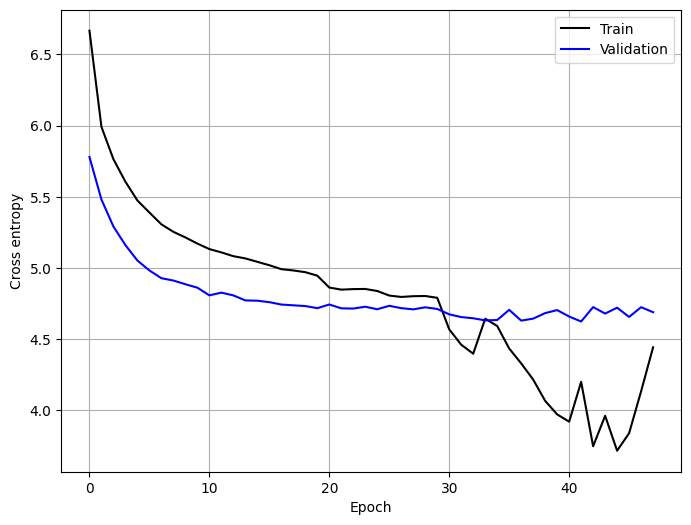

In [111]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.grid(True)
plt.legend()

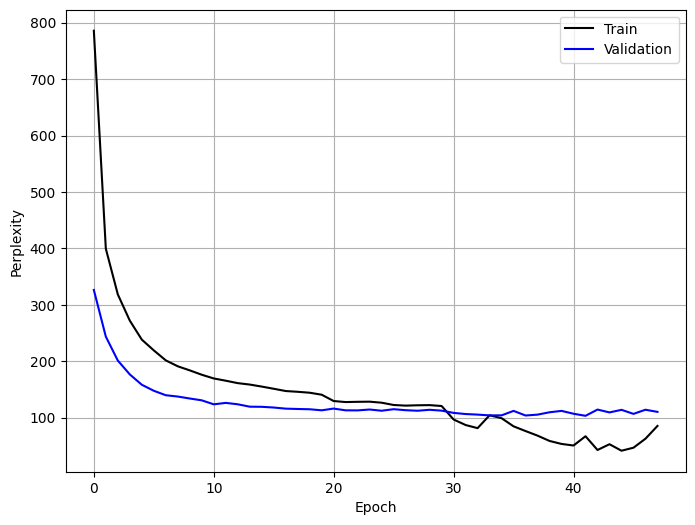

In [112]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label='Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(True)
plt.legend()

-------

# 15_Test

In [113]:
model= torch.load(f'{project_path}awd_model.pt')
model.eval()
with torch.no_grad():
  loss_test, metric_test= evaluate(model, test_loader, loss_fn, metric)
  print(f'Test: Loss= {loss_test:.1f}, Metric= {metric_test:.1f}')

Test: Loss= 4.6, Metric= 98.5


------------

# 16_Text Generator

In [114]:
def generate(prompt, max_seq_len, model, tokenizer, vocab, temperature= 0.5):
  indices= vocab(tokenizer(prompt))
  itos= vocab.get_itos()

  for i in range(max_seq_len):
    with torch.no_grad():
      prediction= model(torch.LongTensor(indices).to(device))

    probs= torch.softmax(prediction[-1]/temperature, dim=0)

    idx= vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx= torch.multinomial(probs, num_samples= 1).item()

    token= itos[idx]
    prompt +=' ' +token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [115]:
prompt= 'In a galaxy far, far away, there'
prompt= 'The sun was setting in the'
prompt= 'Once upon a time, there lived a young princess named'
prompt= 'What is the meaning '
prompt= 'I\'m not in danger, i am the'

model= torch.load(f'{project_path}awd_model.pt')
model.eval()

generate(prompt, 35, model, tokenizer, vocab)

"I'm not in danger, i am the sole to do so ."